In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import joblib



from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge,RidgeCV,Lasso,LassoCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from xgboost import XGBRegressor






# Goal: 
We wan to help  commercial crab farmers to known the right age of their  crabs. This will help  them decide if and when to harvest the crabs. Beyond a certain age, there is negligible growth in crab's physical characteristics and hence, it is important to time the harvesting to reduce cost and increase profit. 

Also, we want to understand the different physical feature changes with age.

Let's start by Loading our Data

In [2]:
url="C://Users//Nii.Sowah//Desktop//DS//ml_proj2/Datasets/CrabAgePrediction.csv"
crab_df=pd.read_csv(url)


Now lets clean up our Data and do some EDA

EDA Questions:

1. What is the average age of a Male Crab
2. What is the average age of a Female Crab
3. Univariate Analysis: 
a.what's the relationship between the Lenght and Age
b.what's the relationship between the Diameter and Age
c.what's the relationship between the Height and Age
d.what's the relationship between the Weight and Age

4. Multivariate Analysis:
a. Is there a relationship between the Shucked Weight,Viscera Weight and Age?
	

In [3]:
crab_df.Age.mean()

9.954790649884409

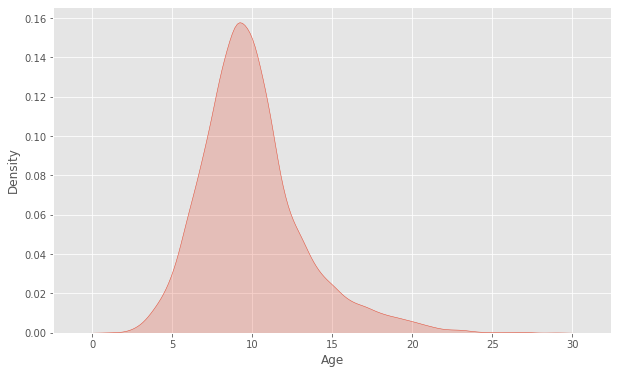

In [4]:
#We will like to categorise the height and weights, this is because the variation is wide over decimal places.
#let's plot so you can understand 
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
sns.kdeplot(data=crab_df,x=crab_df['Age'],fill=True)
plt.show()

From the above we can clearly see that, the average age of our crabs is between 9.9.
the oldest crab is over 25years.

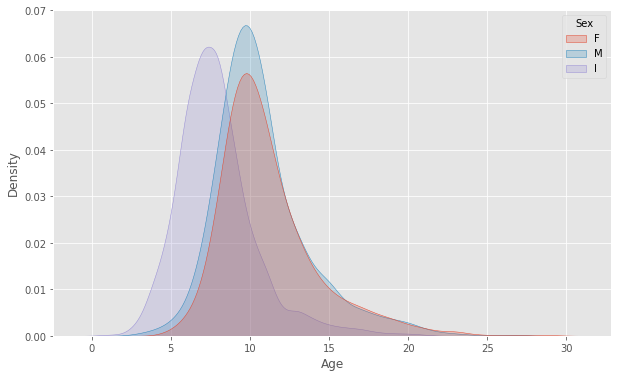

In [5]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
sns.kdeplot(data=crab_df,x=crab_df['Age'],hue=crab_df['Sex'],fill=True)
plt.show()

In [6]:
crab_df['Height'].value_counts().sort_index(ascending=True)
bins=[0,0.3,0.5,3]
crab_df['Cat_Height']=pd.cut(x=crab_df['Height'],bins=bins,labels=['Short','Medium','Heavy'])

crab_df.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Cat_Height
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9,Medium
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6,Short
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6,Short
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10,Short
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6,Short


In [7]:
px.box(crab_df,x=crab_df['Sex'],y=crab_df['Age'])

Female Crabs have a mean age of 10 and max age of 29
Male Crabs have also have a mean age of 10

In [8]:
px.scatter(crab_df,x=crab_df['Age'],y=crab_df['Height'])

Crab height doesn't increase reciprocal to the age. We have crabs age 29 having a height of 0.5

In [9]:
px.scatter(crab_df,x=crab_df['Age'],y=crab_df['Weight'])

In [10]:
crab_df['Weight'].value_counts()

5.556502     7
6.307764     7
32.162508    7
13.536886    6
14.004653    6
            ..
34.359594    1
40.653183    1
5.400580     1
38.470272    1
4.068153     1
Name: Weight, Length: 2343, dtype: int64

In [11]:
px.scatter(crab_df,x=crab_df['Age'],y=crab_df['Shucked Weight'])

In [12]:
px.scatter(crab_df,x=crab_df['Age'],y=crab_df['Viscera Weight'])

In [13]:


crab_df=crab_df.rename(columns={"Shucked Weight":"Shucked_Weight","Viscera Weight":"Viscera_Weight","Shell Weight":"Shell_Weight"})

crab_df.head()

,Sex,Length,Diameter,Height,Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Age,Cat_Height
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9,Medium
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6,Short
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6,Short
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10,Short
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6,Short


Let's look at the correlation matrix. that will give us an idea on which features will be important for our anaysis.



<AxesSubplot:>

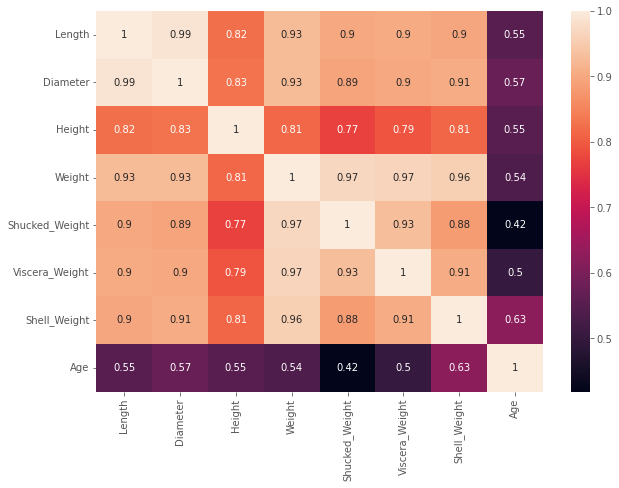

In [14]:

plt.figure(figsize=(10,7))
crab_corr_df=DataFrame(crab_df.corr()['Age'].abs().sort_values(ascending=False))
corr=crab_df.corr().abs()
sns.heatmap(corr,annot=True)

Now let's split our data and train it on a module

In [15]:
Train_df,Test_df=train_test_split(crab_df,random_state=42,test_size=0.3)

In [16]:
Train_df.head()

,Sex,Length,Diameter,Height,Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Age,Cat_Height
2402,F,1.6000,1.3125,0.4375,39.179009,18.313777,8.830869,10.489315,9,Medium
1053,F,1.3000,1.0125,0.3500,23.175716,7.923685,5.187958,7.370870,17,Medium
3232,M,1.2250,0.8875,0.3875,27.810859,13.182517,5.712424,7.101550,8,Medium
22,I,0.9250,0.6875,0.2375,7.285821,2.877474,1.559222,2.338834,6,Short
1745,I,0.8375,0.6500,0.2125,5.443104,2.749901,0.850485,1.530873,6,Short


Now we need to get rid of the Cat Height. This is because there will be collinearity.
And we want to avoid that

In [17]:
def drop_col(DF,row):
    DF=DF.drop([row],axis=1)
    return DF


In [18]:
drop_col(Train_df,'Cat_Height')


,Sex,Length,Diameter,Height,Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Age
2402,F,1.6000,1.3125,0.4375,39.179009,18.313777,8.830869,10.489315,9
1053,F,1.3000,1.0125,0.3500,23.175716,7.923685,5.187958,7.370870,17
3232,M,1.2250,0.8875,0.3875,27.810859,13.182517,5.712424,7.101550,8
22,I,0.9250,0.6875,0.2375,7.285821,2.877474,1.559222,2.338834,6
1745,I,0.8375,0.6500,0.2125,5.443104,2.749901,0.850485,1.530873,6
...,...,...,...,...,...,...,...,...,...
1130,M,1.6500,1.3250,0.4250,39.419980,16.740380,6.010094,12.842323,15
1294,F,1.2875,1.0375,0.3500,19.660378,8.830869,4.309124,5.669900,10
860,M,1.2375,0.9875,0.3000,15.677274,6.350288,3.898056,4.734367,8
3507,I,0.9250,0.7250,0.2000,7.214948,3.061746,1.601747,1.984465,6


Now let's convert the SEX col to numerics so that our ML model can pick it up

In [19]:
cat_trans=Pipeline([('imputer',SimpleImputer(strategy='constant')),('LabelEncoder',OrdinalEncoder())])
num_trans=Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value=0)),('scale',MinMaxScaler())])


Now we will dump this in Joblib so we can pick them up later to develop our app

In [20]:
joblib.dump(cat_trans,"Categorical_pipe.joblib")
joblib.dump(num_trans,"Numerical_pipe.joblib")


['Numerical_pipe.joblib']

In [21]:
Train_df=drop_col(Train_df,'Cat_Height')

In [22]:
Train_df_num=Train_df.drop(['Age'],axis=1)
Target_df=Train_df['Age']

In [23]:
Target_df

2402     9
1053    17
3232     8
22       6
1745     6
        ..
1130    15
1294    10
860      8
3507     6
3174    10
Name: Age, Length: 2725, dtype: int64

In [24]:
num_cols=Train_df_num.select_dtypes(include=np.number).columns
cat_cols=Train_df_num.select_dtypes(include='object').columns

In [25]:
col_trans=ColumnTransformer([("num",num_trans,num_cols),("cat",cat_trans,cat_cols)])
col_trans

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scale', MinMaxScaler())]),
                                 Index(['Length', 'Diameter', 'Height', 'Weight', 'Shucked_Weight',
       'Viscera_Weight', 'Shell_Weight'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='constant')),
                                                 ('LabelEncoder',
                                                  OrdinalEncoder())]),
                                 Index(['Sex'], dtype='object'))])

In [26]:
#joblib.dump(col_trans,"ColumnTransform.joblib")

In [27]:
X_train,X_test,y_train,y_test=train_test_split(Train_df_num,Target_df,test_size=0.3,random_state=42)

NOW Lets get our BaseLine MOdel

In [28]:
#We will use Ridge and Lasso 

model=Lasso()
model_steps=Pipeline([('cols_trans',col_trans),('model',model)])
model_steps.fit(X_train,y_train)
y_pred=model_steps.predict(X_test)
#y_train_pred=model_steps.predict(X_train)
mae=mean_absolute_error(y_test,y_pred)
#tmae=mean_absolute_error(y_train,y_train_pred)
print(mae)
#print(tmae)



2.3997452443256924


In [29]:
cv_results=cross_val_score(model_steps,X_train,y_train,cv=5,scoring="neg_mean_absolute_error")
np.mean(-cv_results)

2.3838576517077024

In [30]:
model=Ridge()
model_steps=Pipeline([('cols_trans',col_trans),('model',model)])
model_steps.fit(X_train,y_train)
y_pred=model_steps.predict(X_test)
#y_train_pred=model_steps.predict(X_train)
mae=mean_absolute_error(y_test,y_pred)
#tmae=mean_absolute_error(y_train,y_train_pred)
print(mae)
#print(tmae)

1.6864339701328475


In [31]:
cv_results=cross_val_score(model_steps,X_train,y_train,cv=5,scoring="neg_mean_absolute_error")
np.mean(-cv_results)

1.6360669028517456

In [32]:
model=RidgeCV()
model_steps=Pipeline([('cols_trans',col_trans),('model',model)])
model_steps.fit(X_train,y_train)
y_pred=model_steps.predict(X_test)
#y_train_pred=model_steps.predict(X_train)
mae=mean_absolute_error(y_test,y_pred)
#tmae=mean_absolute_error(y_train,y_train_pred)
print(mae)
#print(tmae)

1.67488641589465


In [33]:
cv_results=cross_val_score(model_steps,X_train,y_train,cv=5,scoring="neg_mean_absolute_error")
np.mean(-cv_results)

1.6246712742334004

In [34]:
model=RandomForestRegressor(criterion="absolute_error")
model_steps=Pipeline([('cols_trans',col_trans),('model',model)])
model_steps.fit(X_train,y_train)
y_pred=model_steps.predict(X_test)
#y_train_pred=model_steps.predict(X_train)
mae=mean_absolute_error(y_test,y_pred)
#tmae=mean_absolute_error(y_train,y_train_pred)
print(mae)
#print(tmae)

1.5804095354523227


In [35]:
cv_results=cross_val_score(model_steps,X_train,y_train,cv=5,scoring="neg_mean_absolute_error")
cv_results

array([-1.64767016, -1.49043194, -1.58278215, -1.62908136, -1.61805774])

In [36]:
model=GradientBoostingRegressor(loss="absolute_error")
model_steps=Pipeline([('cols_trans',col_trans),('model',model)])
model_steps.fit(X_train,y_train)
y_pred=model_steps.predict(X_test)
#y_train_pred=model_steps.predict(X_train)
mae=mean_absolute_error(y_test,y_pred)
#tmae=mean_absolute_error(y_train,y_train_pred)
print(mae)
#print(tmae)

1.5666444276062124


In [37]:
model=xgb.XGBRegressor(eval_metric=['mae'],n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8,random_state=42)
model_steps=Pipeline([('cols_trans',col_trans),('model',model)])
model_steps.fit(X_train,y_train)

cv_results=cross_val_score(model_steps,X_train,y_train,cv=5,scoring="neg_mean_absolute_error")
np.mean(cv_results)
#y_pred=model_steps.predict(X_test)
#y_train_pred=model_steps.predict(X_train)
#mae=mean_absolute_error(y_test,y_pred)
#tmae=mean_absolute_error(y_train,y_train_pred)
#print(mae)
#print(tmae)

-1.6343601466745414

In [38]:
model.eval_metric

['mae']

In [39]:
cv_results=cross_val_score(model_steps,X_train,y_train,cv=5,scoring="neg_mean_absolute_error")
np.mean(-cv_results)

1.6343601466745414

In [40]:
dict_model={}
list_model=[]

model_1=RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=7,random_state=42)
model_2=GradientBoostingRegressor(n_estimators=100,loss='absolute_error',learning_rate=0.01,max_depth=7,random_state=42)
model_3=xgb.XGBRegressor(eval_metric=['mae'],n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8,random_state=42)
model_name=['RandomForestReg','GradientBoostReg','XgboostReg']
scoring=["neg_mean_absolute_error","neg_mean_squared_error","neg_root_mean_squared_error","r2"]

for model,m_name in zip([model_1,model_2,model_3],model_name):
    model_steps=Pipeline([('cols_trans',col_trans),('model',model)])
    for scor in scoring:
        cv_results=cross_val_score(model_steps,X_train,y_train,cv=5,scoring=scor,n_jobs=-1)
        score_=np.abs(cv_results)
        score_=np.mean(score_)
        dict_model['Model']=m_name
        dict_model[scor]=score_
    list_model.append(dict_model.copy())

    



In [41]:
DataFrame(list_model)

,Model,neg_mean_absolute_error,neg_mean_squared_error,neg_root_mean_squared_error,r2
0,RandomForestReg,1.539425,5.143066,2.263083,0.505159
1,GradientBoostReg,1.751525,6.388629,2.516756,0.391656
2,XgboostReg,1.634360,5.445687,2.329272,0.475376


from the metrics we chose we see Xgboost does well with 3 out ot of the 4 metrics

Now we will have to fine tune our module then save it 
 

In [42]:
xgb_reg=xgb.XGBRegressor(eval_metric=['mae'],n_estimators=100,
                               max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8,random_state=42)

model=Pipeline([('cols_trans',col_trans),('model',xgb_reg)])

param_range=np.arange(100,1000,20)
scoring=["neg_mean_absolute_error","neg_mean_squared_error","neg_root_mean_squared_error","r2"]

param_grid=[{'model__n_estimators':param_range,'model__eval_metric':['mae','rmse']}]

rs=RandomizedSearchCV(estimator=model,param_distributions=param_grid,scoring="neg_mean_absolute_error",cv=10,n_jobs=-1)
rs=rs.fit(X_train,y_train)

print(rs.best_estimator_)



Pipeline(steps=[('cols_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  Index(['Length', 'Diameter', 'Height', 'Weight', 'Shucked_Weight',
       'Viscera_Weight', 'Shell_Weight'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant...
                              eval_metric='mae', fea

In [43]:
print(rs.best_params_)
print(rs.best_estimator_)

{'model__n_estimators': 280, 'model__eval_metric': 'mae'}
Pipeline(steps=[('cols_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  Index(['Length', 'Diameter', 'Height', 'Weight', 'Shucked_Weight',
       'Viscera_Weight', 'Shell_Weight'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='consta

In [44]:
model_2=rs.best_estimator_

In [45]:
rsxgb_reg=xgb.XGBRegressor(eval_metric=['mae'],n_estimators=180,
                               max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8,random_state=42)

model=Pipeline([('cols_trans',col_trans),('model',xgb_reg)])

In [46]:
model.fit(X_train,y_train)

Pipeline(steps=[('cols_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  Index(['Length', 'Diameter', 'Height', 'Weight', 'Shucked_Weight',
       'Viscera_Weight', 'Shell_Weight'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant...
                              eval_metric=['mae'], feature_types=None, gamma=0,
                              gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.100000001, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=7, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto', ...))])

In [47]:
weight=model.steps[1][1].feature_importances_

In [48]:
num_cols=model.named_steps['cols_trans'].transformers_[0][2]
cat_cols=model.named_steps['cols_trans'].transformers_[1][2]


In [49]:
feature=list(num_cols) + list (cat_cols)
feature

['Length',
 'Diameter',
 'Height',
 'Weight',
 'Shucked_Weight',
 'Viscera_Weight',
 'Shell_Weight',
 'Sex']

In [50]:
feat=DataFrame(feature)
weights=DataFrame(weight)

imp_df=pd.concat([feat,weights],axis=1,keys=['Feature','Weight'])

imp_df=imp_df.droplevel(1,axis=1)

In [51]:
imp_df.sort_values(by="Weight",ascending=False)

,Feature,Weight
6,Shell_Weight,0.378055
2,Height,0.170400
4,Shucked_Weight,0.113196
3,Weight,0.078768
7,Sex,0.074516
5,Viscera_Weight,0.072167
1,Diameter,0.056744
0,Length,0.056152


In [52]:
Test_df=drop_col(Test_df,'Cat_Height')




In [53]:
X_valid=Test_df.drop(['Age'],axis=1)
y_valid=Test_df['Age']

In [54]:
model.fit(X_train,y_train)
pred=model.predict(X_valid)
mean_absolute_error(y_valid,pred)

1.532563147275415

In [55]:
X_new_train=col_trans.transform(X_train)
rsxgb_reg.fit(X_new_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=['mae'], feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=180, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [56]:

joblib.dump(rsxgb_reg,"rsxgb_reg.joblib")

['rsxgb_reg.joblib']

In [57]:
model

Pipeline(steps=[('cols_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  Index(['Length', 'Diameter', 'Height', 'Weight', 'Shucked_Weight',
       'Viscera_Weight', 'Shell_Weight'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant...
                              eval_metric=['mae'], feature_types=None, gamma=0,
                              gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.100000001, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=7, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto', ...))])

In [58]:
X_valid

,Sex,Length,Diameter,Height,Weight,Shucked_Weight,Viscera_Weight,Shell_Weight
3546,I,0.7750,0.5875,0.1750,4.280774,1.786018,1.148155,1.275727
2398,M,1.1625,0.8875,0.3000,15.067759,7.725239,2.749901,3.954755
3865,F,1.0875,0.8750,0.3000,12.998246,5.443104,2.834950,3.685435
1187,I,1.3500,0.9875,0.3375,18.583097,7.668540,4.394172,5.443104
315,I,0.8250,0.6000,0.1875,4.620969,2.112038,0.935534,1.360776
...,...,...,...,...,...,...,...,...
2582,F,1.5375,1.2875,0.4250,32.318430,12.204460,6.364463,11.906790
361,I,1.3375,1.0000,0.3250,18.625622,8.037083,4.592619,4.961163
135,F,1.5250,1.2000,0.4750,36.726777,14.784264,9.142714,10.347568
1134,I,0.3750,0.2500,0.0625,0.425243,0.127573,0.113398,0.141747


In [64]:
model=rs.best_estimator_

model.fit(X_train,y_train)

joblib.dump(model,"model.joblib")

['model.joblib']

In [75]:
model=joblib.load("model.joblib")

X_in={'Length':8.0,
    'Diameter':9.0,
    'Height':11.0,
    'Weight':25.2,
    'Shucked_Weight':5.0,
    'Viscera_Weight':45.5,
    'Shell_Weight':12.5,
    'Sex':'M'}

df_in=DataFrame([X_in.values()],columns=X_in.keys())

model.predict(df_in)

array([14.412238], dtype=float32)

In [62]:
X_valid

,Sex,Length,Diameter,Height,Weight,Shucked_Weight,Viscera_Weight,Shell_Weight
3546,I,0.7750,0.5875,0.1750,4.280774,1.786018,1.148155,1.275727
2398,M,1.1625,0.8875,0.3000,15.067759,7.725239,2.749901,3.954755
3865,F,1.0875,0.8750,0.3000,12.998246,5.443104,2.834950,3.685435
1187,I,1.3500,0.9875,0.3375,18.583097,7.668540,4.394172,5.443104
315,I,0.8250,0.6000,0.1875,4.620969,2.112038,0.935534,1.360776
...,...,...,...,...,...,...,...,...
2582,F,1.5375,1.2875,0.4250,32.318430,12.204460,6.364463,11.906790
361,I,1.3375,1.0000,0.3250,18.625622,8.037083,4.592619,4.961163
135,F,1.5250,1.2000,0.4750,36.726777,14.784264,9.142714,10.347568
1134,I,0.3750,0.2500,0.0625,0.425243,0.127573,0.113398,0.141747
